In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import cmocean.cm as cmo
import cmocean
import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature
plt.rcParams['figure.figsize'] = [5, 3]

In [3]:
import matplotlib.patches as mpath
import matplotlib.path as mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as ctk
import matplotlib.ticker as mticker
import numpy as np

def plot_antarctic_plot(ds, ax, cmap=None, norm=None, 
                       exp="forced", variable="mass_tendency", 
                       mass_flux_units_conversion=1,
                       xlims=[-45, 45], ylims=[-90, -30],
                       use_xlim_ylim=True,
                       xticks=None,
                       yticks=None,
                       lon_spacing=15,
                       lat_spacing=10):
    
    # Extract data and apply unit conversion
    wmt_mean_budget = mass_flux_units_conversion * ds.sel(exp=exp)[variable]
    wmt_mean_budget = wmt_mean_budget.where(np.abs(wmt_mean_budget) > 1e-8)
    
    # Create boundary path
    rect = mpath.Path([[xlims[0], ylims[0]], 
                      [xlims[1], ylims[0]],
                      [xlims[1], ylims[1]], 
                      [xlims[0], ylims[1]], 
                      [xlims[0], ylims[0]]]).interpolated(50)
    
    # Transform the path
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    
    # Plot data
    cm = ax.pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                      wmt_mean_budget, 
                      cmap=cmap, 
                      transform=ccrs.PlateCarree(),
                      norm=norm)
    
    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')

    # Set the boundary
    ax.set_boundary(rect_in_target)
    
    # Draw gridlines with updated settings
    gl = ax.gridlines(draw_labels=True, 
                      crs=ccrs.PlateCarree(),
                    xlocs=range(xlims[0],xlims[1] + lon_spacing,lon_spacing), 
                    ylocs=range(ylims[0],ylims[1] + lat_spacing,lat_spacing),
                     x_inline=False, 
                     y_inline=False, 
                     linestyle='dashed',
                      alpha=0.5)
    gl.bottom_labels = False  # Remove bottom labels
    gl.right_labels = False   # Remove right labels
    gl.ylabels_left = False

    # gl.xlabel_style = {'rotation': -90}

    
    # # Set the extent or xlim/ylim based on parameter
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())
    # else:
    # ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())
    
    return cm

### Load in data

In [4]:
# sigma = 37.00
sigma = 36.974
toSv = 1/1035*1e-6
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

In [5]:
ds_sfc = xr.open_dataset(datadir(f"/model/Southern_Ocean_Surface_Advection_and_Tendency_sigma_{sigma}.nc"))

In [6]:
ds_sfc["surface_ocean_flux_advective_negative_rhs"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_heat"] + ds_sfc["surface_ocean_flux_advective_negative_rhs_salt"]
ds_sfc["BF_Adv"] = ds_sfc["surface_ocean_flux_advective_negative_rhs"]
ds_sfc["BF_NonAdv"] = ds_sfc["boundary_fluxes"] - ds_sfc["BF_Adv"]

ds_sfc["surface_boundary_fluxes"] = ds_sfc["boundary_fluxes"] - ds_sfc["bottom_flux_heat"]

ds_sfc["boundary_fluxes_heat"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds_sfc["surface_exchange_flux_heat"] +\
                                 ds_sfc["frazil_ice_heat"]

ds_sfc["boundary_fluxes_salt"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds_sfc["surface_exchange_flux_salt"]

ds_sfc["diffusion"] = ds_sfc["diffusion_salt"] +  ds_sfc["diffusion_heat"]

In [7]:
sns.set_context("paper")

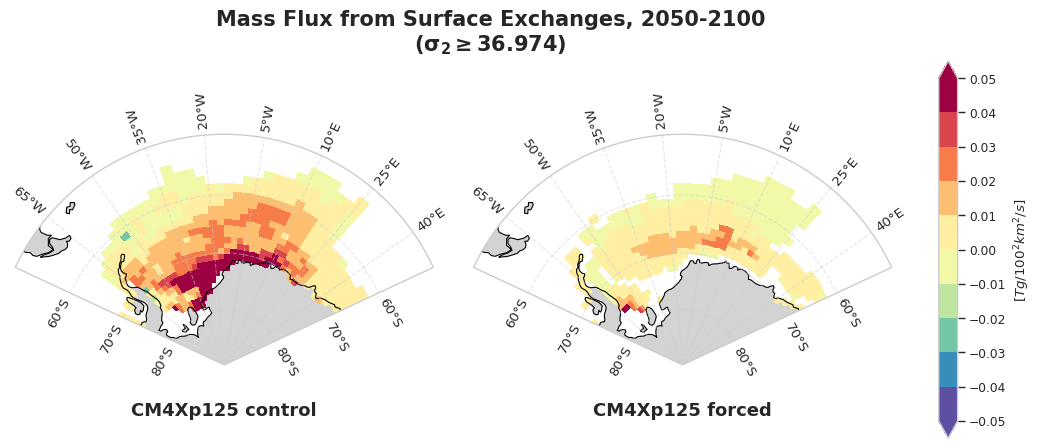

In [8]:
mass_flux_units_conversion = toTg / (ds_sfc.areacello / (100e3 **2 ))
mass_flux_units = r"$Tg/100^2 km^2 / s$"

cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.05, 0.0501, 0.01) 

boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)
density_title = r"$\mathbf{(\sigma_2 \geq 36.974)}$"

experiments = ['control', 'forced']

xlims=[-80, 50]; ylims=[-90, -50]
lon1, lon2 = xlims
lat1, lat2 = ylims

proj = ccrs.Stereographic(central_longitude=(lon1+lon2)*0.5, 
                                central_latitude=-90)

fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                 subplot_kw={'projection': proj})

width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "surface_boundary_fluxes", 
                        mass_flux_units_conversion = mass_flux_units_conversion,
                            xlims=xlims, ylims=ylims,
                       use_xlim_ylim=True)  
fig.tight_layout()
fig.suptitle("Mass Flux from Surface Exchanges, " + '-'.join(times) + "\n" + density_title, 
             fontweight = "bold", fontsize = 15)  
for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)
fig.savefig(plotsdir("commitee_figures/MassFluxesWedell.png"), dpi = 200, bbox_inches = "tight")

In [57]:
ds_sfc['sources_mask'] = mass_flux_units_conversion * wmt_mean["surface_boundary_fluxes"].sel(exp = 'control')
ds_sfc['sources_mask'] = xr.where( np.abs(ds_sfc['sources_mask'])  > 1e-8, 1, np.nan)

ds_sfc['wedell_mask'] = (ds_sfc['sources_mask'] * (ds_sfc.geolon > -65) * (ds_sfc.geolon < 45) * (ds_sfc.geolat < -40))
ds_sfc['wedell_mask']  = ds_sfc['wedell_mask'].where(ds_sfc['wedell_mask']  != 0.0)
ds_sfc['wedell_mask_weighted'] = ds_sfc['wedell_mask'] * np.abs(wmt_mean["surface_boundary_fluxes"].sel(exp = 'control'))
ds_sfc['wedell_mask_weighted'] = ds_sfc['wedell_mask_weighted']  / ds_sfc['wedell_mask_weighted'].sum(["xh", "yh"])

Text(0.5, 0.9, 'Weddell Sea Mask')

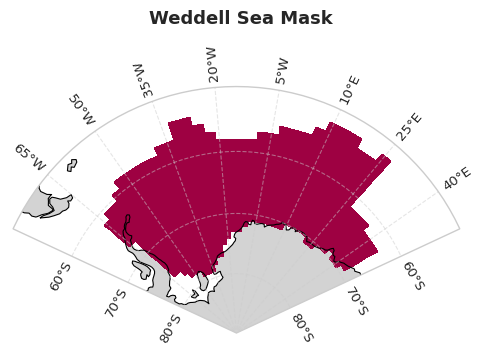

In [58]:
fig, ax = plt.subplots(figsize = (5, 5), subplot_kw={'projection': proj})
width = 0.25
curr_width = 0.0

plot_antarctic_plot(ds_sfc, ax, cmap = cmap, norm = norm, 
                       exp = exp, variable = 'wedell_mask', 
                        mass_flux_units_conversion = 1,
                            xlims=xlims, ylims=ylims,
                       use_xlim_ylim=True)  
fig.tight_layout()
fig.suptitle("Weddell Sea Mask", fontweight = "bold", fontsize = 13, y = 0.9)  

In [59]:
mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg

In [60]:
wedell_vars_seasonal = ds_sfc.sel(time = slice(times[0], times[1])).groupby("time.month").mean("time") * toTg
wedell_vars_seasonal = (wedell_vars_seasonal * ds_sfc['wedell_mask']).sum(["xh", "yh"]) 

In [62]:
# Define colors using a mix of qualitative and sequential colors
colors = {
    "Mass Exchange Salt Flux": "#2E86AB",       # Steel blue
    "Direct Exchange Heat Flux": "#F24236",     # Coral red
    "Direct Exchange Salt Flux": "#8FB339",     # Olive green
    "Frazil Ice Heat Flux": "#7C77B9",         # Muted purple
    "Mass Exchange Heat Flux": "#F58B4C"        # Orange
}


In [63]:
wedell_vars = ds_sfc.groupby("time.year").mean("time") * toTg
wedell_vars = (wedell_vars * ds_sfc['wedell_mask']).sum(["xh", "yh"]) 

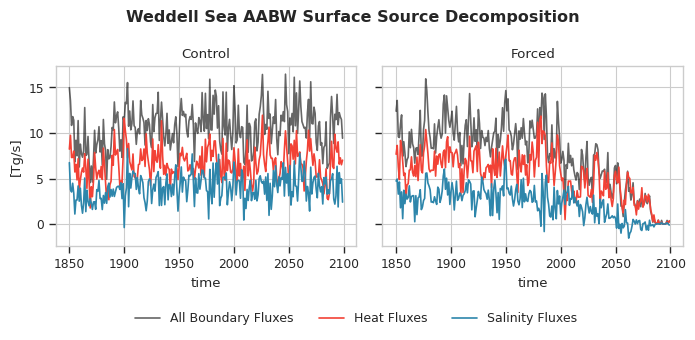

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

for i, expt in enumerate(["control", "forced"]):
    wedell_vars["surface_boundary_fluxes"].sel(exp=expt).plot(
        ax=ax[i], label="All Boundary Fluxes", color="k", alpha = 0.6)
    wedell_vars["boundary_fluxes_heat"].sel(exp=expt).plot(
        ax=ax[i], label="Heat Fluxes", color=colors["Direct Exchange Heat Flux"])
    wedell_vars["boundary_fluxes_salt"].sel(exp=expt).plot(
        ax=ax[i], label="Salinity Fluxes", color=colors["Mass Exchange Salt Flux"])
    ax[i].set_title(expt.capitalize())
    ax[i].set_ylabel("")

    ax[i].set_xlabel("time")
    ax[i].tick_params(bottom=True, left=True)

fig.suptitle("Weddell Sea AABW Surface Source Decomposition", fontweight = "bold")

fig.tight_layout()
ax[0].legend(
    bbox_to_anchor=(1, -0.4),
    loc='center',
    ncol=3,
    fontsize=9,
    frameon=False,
    borderaxespad=0.
)
ax[0].set_ylabel(f"[{mass_flux_units}]")
fig.savefig(plotsdir("commitee_figures/MassFluxesSourceDecomp_HeatSalt.png"), dpi = 200, bbox_inches = "tight")

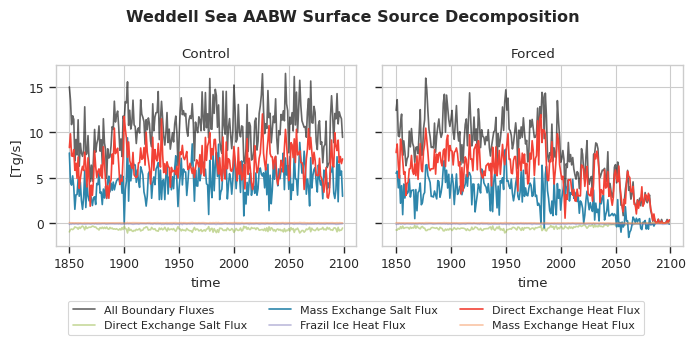

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

alpha = 0.5
for i, expt in enumerate(["control", "forced"]):
    wedell_vars["surface_boundary_fluxes"].sel(exp=expt).plot(
        ax=ax[i], label="All Boundary Fluxes", color="k", alpha = 0.6)
    
    wedell_vars["surface_exchange_flux_salt"].sel(exp=expt).plot(
        ax=ax[i], label="Direct Exchange Salt Flux", color=colors["Direct Exchange Salt Flux"], alpha = alpha)
    
    wedell_vars["surface_ocean_flux_advective_negative_rhs_salt"].sel(exp=expt).plot(
        ax=ax[i], label="Mass Exchange Salt Flux", color=colors["Mass Exchange Salt Flux"])

    wedell_vars["frazil_ice_heat"].isel(exp=1).plot(
        ax=ax[i], label="Frazil Ice Heat Flux", color=colors["Frazil Ice Heat Flux"], alpha = alpha)
    
    wedell_vars["surface_exchange_flux_heat"].sel(exp=expt).plot(
        ax=ax[i], label="Direct Exchange Heat Flux", color=colors["Direct Exchange Heat Flux"])
    
    wedell_vars["surface_ocean_flux_advective_negative_rhs_heat"].sel(exp=expt).plot(
        ax=ax[i], label="Mass Exchange Heat Flux", color=colors["Mass Exchange Heat Flux"], alpha = alpha)
    
    ax[i].set_title(expt.capitalize())
    ax[i].set_ylabel("")

    ax[i].set_xlabel("time")
    ax[i].tick_params(bottom=True, left=True)

fig.suptitle("Weddell Sea AABW Surface Source Decomposition", fontweight = "bold")

fig.tight_layout()
ax[0].legend(
    bbox_to_anchor=(1, -0.4),
    loc='center',
    ncol=3,
    fontsize=8,
    frameon=True,
    borderaxespad=0.
)

ax[0].set_ylabel(f"[{mass_flux_units}]")
fig.savefig(plotsdir("commitee_figures/MassFluxesSourceDecomp_All.png"), dpi = 200, bbox_inches = "tight")

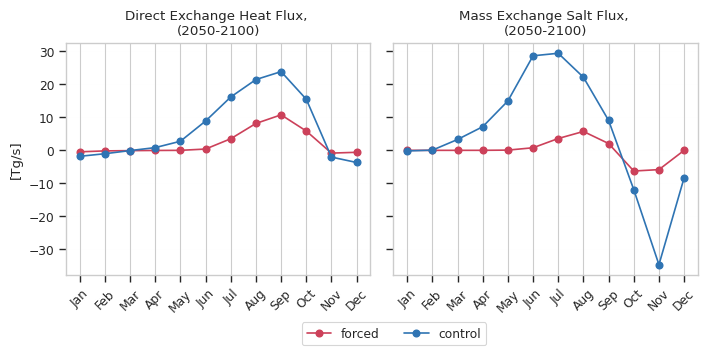

In [124]:
density_title = r"$(\sigma_2 \geq 36.974)$"

experiments = ['forced', 'control']
nexpt = len(experiments)

fig, axes = plt.subplots(1, 2, figsize = (7, 3), 
                         sharey = True, sharex = True)

width = 0.25
times = ("2050", "2100")

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
varrs = ["surface_exchange_flux_heat", "surface_ocean_flux_advective_negative_rhs_salt"]
for (j, varn) in enumerate(varrs):
    ax = axes[j]
    for (i, exp) in enumerate(experiments):
        wmt_mean_budget =  wedell_vars_seasonal.sel(exp = exp)[varn]
        ax.plot(wmt_mean_budget.month * 1.75, wmt_mean_budget, 
                             marker = "o", label = exp, color = expt_colors[exp])
    ax.set_xticks(wmt_mean_budget.month * 1.75, months, rotation = 45)
    ax.tick_params(bottom=True, left=True)
    ax.grid(alpha = 0.01, axis = "y")

fig.tight_layout()

axes[0].set_title("Direct Exchange Heat Flux, \n" + '(' + '-'.join(times) + ')')
axes[1].set_title("Mass Exchange Salt Flux, \n" + '(' + '-'.join(times) + ')')

axes[0].set_ylabel(f"[{mass_flux_units}]")

axes[1].legend(ncols = 3, 
               loc = (-0.3, -0.3), 
               frameon = True)

# 
fig.savefig(plotsdir("commitee_figures/MassFluxesWedellSeasonal.png"), dpi = 200, bbox_inches = "tight")

In [49]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='04:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=5)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 04:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.58:38078 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.58:38078,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [66]:
def get_sigma2_at_surface(ds, keep_vars = False): 
    p = 0.0 * ds.sos


    sa = xr.apply_ufunc(
        gsw.SA_from_SP,
        ds.sos,
        p,
        ds.lon,
        ds.lat,
        dask="parallelized",
    )
    ct = xr.apply_ufunc(
        gsw.CT_from_t,
        sa,
        ds.tos,
        p,
        dask="parallelized"
    )

    sigma2_surf = xr.apply_ufunc(
        gsw.sigma2,
        sa,
        ct,
        dask="parallelized"
    )
    return sigma2_surf

In [67]:
variables = ["tos", "sos", "siconc", "LSNK", "LSRC", "SNOWFL", 
             "RAIN", "EVAP", "evs", "prlq", "prsn", "rlntds",
             "sfdsi", "siconc", "wfo", "fsitherm", "hflso", "hfsso", 
             "sithick", "taux", "tauy", "boundary_forcing_heat_tendency", 
             "rlntds", "ficeberg", "friver", "vprec", "wfo"]

def preprocess(ds): 
    ds = ds[variables]
    ds["sigma2_surf"] = get_sigma2_at_surface(ds)
    ds["sivol"] = ds["siconc"] * ds["sithick"] * ds["areacello"]
    return ds

In [68]:
import glob
import xarray as xr

datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/" + x
datafiles = glob.glob(datadir("CM4Xp125*"))[20:]
datafiles = sorted(datafiles)

dsog = xr.open_mfdataset(
        datafiles[0],
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr",)
        # preprocess=preprocess)
dsog

<xarray.Dataset> Size: 26GB
Dimensions:                         (exp: 2, time: 60, yh: 112, xh: 120,
                                     sigma2_l: 74, yq: 113, xq: 121,
                                     sigma2_i: 75, time_bounds: 61)
Coordinates: (12/30)
    areacello                       (yh, xh) float64 108kB dask.array<chunksize=(112, 120), meta=np.ndarray>
    deptho                          (yh, xh) float64 108kB dask.array<chunksize=(112, 120), meta=np.ndarray>
    dxCv                            (yq, xh) float64 108kB dask.array<chunksize=(113, 120), meta=np.ndarray>
    dyCu                            (yh, xq) float64 108kB dask.array<chunksize=(112, 121), meta=np.ndarray>
  * exp                             (exp) object 16B 'forced' 'control'
    geolat                          (yh, xh) float64 108kB dask.array<chunksize=(112, 120), meta=np.ndarray>
    ...                              ...
    wet_u                           (yh, xq) float64 108kB dask.array<chunksize=(112, 121), meta=np.ndarray>
    wet_v                           (yq, xh) float64 108kB dask.array<chunksize=(113, 120), meta=np.ndarray>
  * xh                              (xh) int64 960B 0 1 2 3 ... 116 117 118 119
  * xq                              (xq) int64 968B 0 1 2 3 ... 117 118 119 120
  * yh                              (yh) int64 896B 0 1 2 3 ... 108 109 110 111
  * yq                              (yq) int64 904B 0 1 2 3 ... 109 110 111 112
Data variables: (12/51)
    EVAP                            (exp, time, yh, xh) float64 13MB dask.array<chunksize=(2, 60, 112, 120), meta=np.ndarray>
    LSNK                            (exp, time, yh, xh) float64 13MB dask.array<chunksize=(2, 60, 112, 120), meta=np.ndarray>
    LSRC                            (exp, time, yh, xh) float64 13MB dask.array<chunksize=(2, 60, 112, 120), meta=np.ndarray>
    RAIN                            (exp, time, yh, xh) float64 13MB dask.array<chunksize=(2, 60, 112, 120), meta=np.ndarray>
    SNOWFL                          (exp, time, yh, xh) float64 13MB dask.array<chunksize=(2, 60, 112, 120), meta=np.ndarray>
    S_advection_xy                  (exp, time, sigma2_l, yh, xh) float64 955MB dask.array<chunksize=(2, 60, 74, 112, 120), meta=np.ndarray>
    ...                              ...
    tos                             (exp, time, yh, xh) float64 13MB dask.array<chunksize=(2, 60, 112, 120), meta=np.ndarray>
    umo                             (exp, time, sigma2_l, yh, xq) float64 963MB dask.array<chunksize=(2, 60, 74, 112, 121), meta=np.ndarray>
    vert_remap_h_tendency           (exp, time, sigma2_l, yh, xh) float64 955MB dask.array<chunksize=(2, 60, 74, 112, 120), meta=np.ndarray>
    vmo                             (exp, time, sigma2_l, yq, xh) float64 963MB dask.array<chunksize=(2, 60, 74, 113, 120), meta=np.ndarray>
    vprec                           (exp, time, yh, xh) float64 13MB dask.array<chunksize=(2, 60, 112, 120), meta=np.ndarray>
    wfo                             (exp, time, yh, xh) float64 13MB dask.array<chunksize=(2, 60, 112, 120), meta=np.ndarray>
Attributes:
    NCO:                 netCDF Operators version 5.0.1 (Homepage = http://nc...
    associated_files:    areacello: 18500101.D2ocean_static.nc
    description:         The CM4Xp125 experimental design following Griffies ...
    external_variables:  volcello
    filename:            ocean_monthly_z_d2.185001-185412.S_advection_xy.nc
    grid_tile:           N/A
    grid_type:           regular
    history:             Fri Jun  9 01:32:07 2023: ncatted -O -a associated_f...
    model:               CM4Xp125
    provenance:          Diagnostics have been conservatively remapped into m...
    title:               CM4_historical_c192_OM4p125
    version:             v0.2.0

In [69]:
def extract_seasonal_temps(ds, months=[6, 7, 8], years=None):
    # First select specified months
    seasonal = ds.sel(time=ds.time.dt.month.isin(months))
    
    # Add year selection if specified
    if years is not None:
        seasonal = seasonal.sel(time=seasonal.time.dt.year.isin(years))
    
    # Group by both month and year, then take mean
    # This gives us a seasonal average for each year
    seasonal_avg = seasonal.groupby('time.year').mean('time')
    
    return seasonal_avg

In [70]:
ds = xr.open_mfdataset(
        datafiles,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr",
        preprocess=preprocess)
ds = extract_seasonal_temps(ds)

In [71]:
wedell_weights = ds_sfc['wedell_mask'] * ds_sfc.areacello

In [74]:
weighted_wedell_sum = lambda ds: (ds * wedell_weights).sum(["xh", "yh"])
weighted_wedell_avg = lambda ds: (ds * wedell_weights).sum(["xh", "yh"]) / wedell_weights.sum(["xh", "yh"])

In [75]:
def extract_seasonal_temps(ds, months=[6, 7, 8], years=None):
    # First select specified months
    seasonal = ds.sel(time=ds.time.dt.month.isin(months))
    
    # Add year selection if specified
    if years is not None:
        seasonal = seasonal.sel(time=seasonal.time.dt.year.isin(years))
    
    # Group by both month and year, then take mean
    # This gives us a seasonal average for each year
    seasonal_avg = seasonal.groupby('time.year').mean('time')
    
    return seasonal_avg

In [76]:
weighted_vars = weighted_wedell_avg(ds[["tos", "sos", "sigma2_surf"]]).compute()

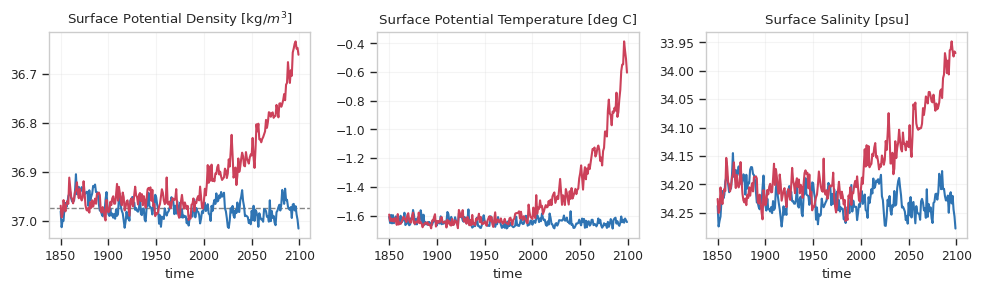

In [77]:
fig, ax = plt.subplots(1, 3, figsize  = (10, 3))

ax[0].axhline([36.974], c = "grey", alpha = 0.95, lw = 1, linestyle = "--")
ax[0].annotate(r"$\sigma_2 = 36.974$", xy=(1800., 37.05), fontsize = 12,
                  xytext=(0, 0), textcoords="offset points",
                  va="center", c = "grey", alpha = 0.95)
ax[0].tick_params(bottom=True, left=True)

for (i, exp) in enumerate(["control", "forced"]):
    ax[0].set_title("Surface Potential Density " + r"[kg/$m^3$]")
    ax[0].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["sigma2_surf"], 
               lw = 1.5, c = expt_colors[exp])
    ax[1].set_title("Surface Potential Temperature [deg C]")
    ax[1].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["tos"], 
               lw = 1.5, c = expt_colors[exp])
    ax[2].set_title("Surface Salinity [psu]")
    ax[2].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["sos"], 
               lw = 1.5, c = expt_colors[exp])
ax[0].invert_yaxis()
ax[2].invert_yaxis()


[a.set_xlabel("time") for a in ax]    
[a.grid(alpha = 0.2) for a in  ax]
[a.tick_params(bottom=True, left=True) for a in  ax]
fig.tight_layout()
fig.savefig(plotsdir("commitee_figures/SurfaceDensity.png"), dpi = 200, bbox_inches = "tight")

In [78]:
weighted_vars = weighted_wedell_avg(ds[["sivol", "sithick", "siconc"]]).compute()

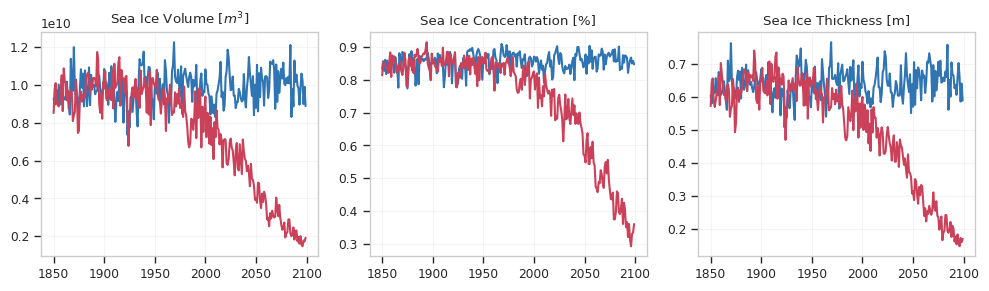

In [79]:
fig, ax = plt.subplots(1, 3, figsize  = (10, 3))

for (i, exp) in enumerate(["control", "forced"]):
    ax[0].set_title("Sea Ice Volume " + r"[$m^3$]")
    ax[0].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["sivol"], 
               lw = 1.5, c = expt_colors[exp])
    ax[1].set_title("Sea Ice Concentration [%]")
    ax[1].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["siconc"], 
               lw = 1.5, c = expt_colors[exp])
    ax[2].set_title("Sea Ice Thickness [m]")
    ax[2].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["sithick"], 
               lw = 1.5, c = expt_colors[exp])

[a.grid(alpha = 0.2) for a in  ax]
[a.tick_params(bottom=True, left=True) for a in  ax]
fig.tight_layout()
fig.savefig(plotsdir("commitee_figures/SurfaceSeaIce.png"), dpi = 200, bbox_inches = "tight")

In [125]:
weighted_vars = weighted_wedell_avg(ds[["hfsso", "hflso", "rlntds"]]).compute()

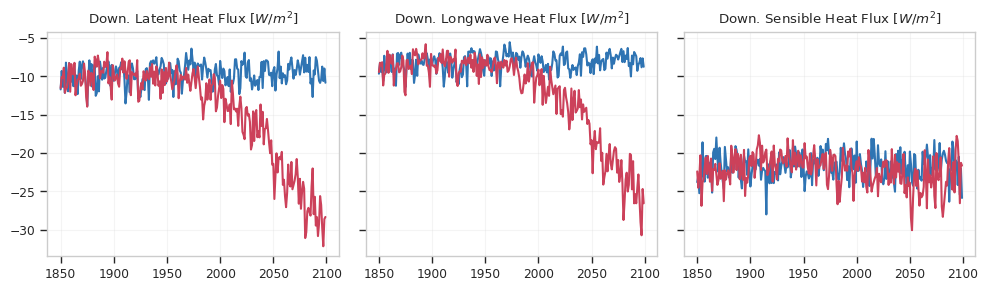

In [126]:
fig, ax = plt.subplots(1, 3, figsize  = (10, 3), sharey = True)

for (i, exp) in enumerate(["control", "forced"]):
    ax[2].set_title("Down. Sensible Heat Flux " + r"[$W/m^2$]")
    ax[2].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["hfsso"], 
               lw = 1.5, c = expt_colors[exp])
    ax[0].set_title("Down. Latent Heat Flux " +  r"[$W/m^2$]")
    ax[0].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["hflso"], 
               lw = 1.5, c = expt_colors[exp])
    ax[1].set_title("Down. Longwave Heat Flux " +  r"[$W/m^2$]")
    ax[1].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["rlntds"], 
               lw = 1.5, c = expt_colors[exp])

[a.grid(alpha = 0.2) for a in  ax]
[a.tick_params(bottom=True, left=True) for a in  ax]
fig.tight_layout()
fig.savefig(plotsdir("commitee_figures/SurfaceHeatFlux.png"), dpi = 200, bbox_inches = "tight")

In [127]:
#Net surface water flux (wfo) = (precip+melt+lrunoff+ice calving-evap)
#https://adcroft.github.io/MOM6/APIs/namespacemom__forcing__type.html
ds["precip"] = ds["prlq"] + ds["prsn"]
ds["melt"] = ds["fsitherm"] +  ds["ficeberg"]

weighted_vars = weighted_wedell_avg(ds[["precip", "melt", "friver", "wfo", "evs"]]).compute()

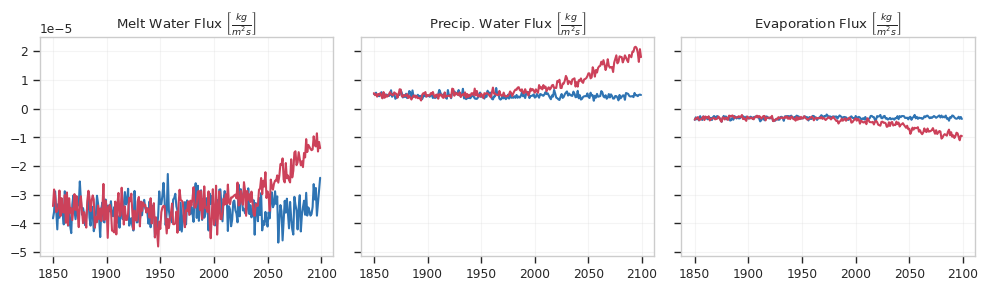

In [128]:
fig, ax = plt.subplots(1, 3, figsize  = (10, 3), sharey = True)

for (i, exp) in enumerate(["control", "forced"]):
    ax[1].set_title("Precip. Water Flux " + r"$\left[\frac{kg}{m^2 s}\right]$")
    ax[1].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["precip"], 
               lw = 1.5, c = expt_colors[exp])
    ax[0].set_title("Melt Water Flux " + r"$\left[\frac{kg}{m^2 s}\right]$")
    ax[0].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["melt"], 
               lw = 1.5, c = expt_colors[exp])
    ax[2].set_title("Evaporation Flux " + r"$\left[\frac{kg}{m^2 s}\right]$")
    ax[2].plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["evs"], 
               lw = 1.5, c = expt_colors[exp])
    
[a.grid(alpha = 0.2) for a in  ax]
[a.tick_params(bottom=True, left=True) for a in  ax]
fig.tight_layout()
fig.savefig(plotsdir("commitee_figures/SurfaceFW.png"), dpi = 200, bbox_inches = "tight")

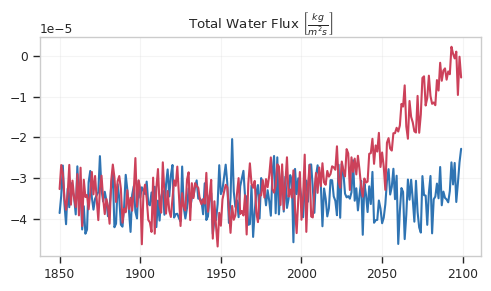

In [132]:
fig, ax = plt.subplots(figsize  = (5, 3), sharey = True)

for (i, exp) in enumerate(["control", "forced"]):
    ax.set_title("Total Water Flux " + r"$\left[\frac{kg}{m^2 s}\right]$")
    ax.plot(weighted_vars.year, 
               weighted_vars.sel(exp = exp)["wfo"], 
               lw = 1.5, c = expt_colors[exp])
    
ax.grid(alpha = 0.2)
ax.tick_params(bottom=True, left=True)
fig.tight_layout()
fig.savefig(plotsdir("commitee_figures/SurfaceWFO.png"), dpi = 200, bbox_inches = "tight")

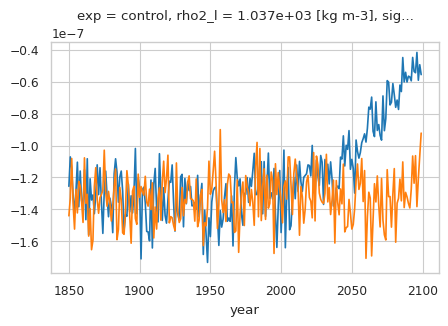

In [90]:
weighted_vars = weighted_wedell_avg(ds["sfdsi"]).compute()
weighted_vars.isel(exp = 0).plot()
weighted_vars.isel(exp = 1).plot()